In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu

%matplotlib inline
sns.set_palette(sns.color_palette("Set1", 2))
plt.rcParams["figure.figsize"] = (16,6)

## Read data

In [2]:
def parse_line(line):
    return [column.split("=")[1] for column in line.split("\t")]

with open("log.txt", "r") as log:
    lines = [line.strip() for line in log.readlines()]

rows = [parse_line(line) for line in lines if line]

In [3]:
data = pd.DataFrame(rows, columns=["slot", "user_id", "ts", "browser", "all_cl"])
data.loc[:, "all_cl"] = data.loc[:, "all_cl"].astype(int)

In [4]:
data.head()

,slot,user_id,ts,browser,all_cl
0,exp,1,2016-03-03,Browser #2,1
1,exp,1,2016-03-03,Browser #2,5
2,exp,1,2016-03-03,Browser #2,1
3,exp,1,2016-03-03,Browser #2,1
4,exp,1,2016-03-03,Browser #2,6


## Analysis

### Task 1

In [5]:
set(data.loc[data.slot == "exp", "user_id"].values) & set(data.loc[data.slot == "control", "user_id"].values)

set()

We have different users in "exp" and "control" groups.

In [6]:
def agg_clicks(data, aggfunc=sum):
    groups = data.groupby('user_id')['all_cl']
    return groups.agg(aggfunc)

def plot_hist(exp, control, title, max_value=50):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set(xlabel="clicks")
    sns.distplot(exp[exp <= max_value], label="exp", ax=ax)
    sns.distplot(control[control <= max_value], label="control", ax=ax)
    plt.legend()

In [7]:
exp_clicks = agg_clicks(data.loc[data.slot == "exp"])
control_clicks = agg_clicks(data.loc[data.slot == "control"])

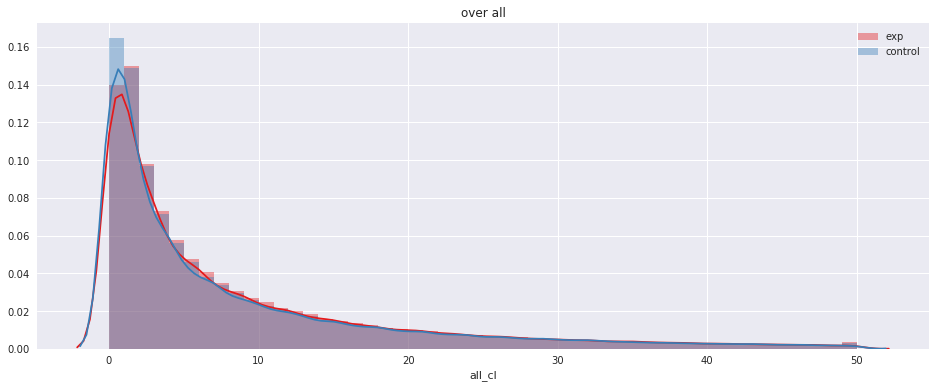

In [8]:
plot_hist(exp_clicks, control_clicks, "over all")

Let's use Mann–Whitney U test.

In [9]:
mannwhitneyu(exp_clicks, control_clicks)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

p-value is very small. <br>
This means that the experiment has an effect.

### Total clicks count

In [10]:
exp_clicks_total = data.loc[data.slot == "exp", "all_cl"].sum()
print("Exp clicks total count: {}".format(exp_clicks_total))

Exp clicks total count: 3261823


In [11]:
control_clicks_total = data.loc[data.slot == "control", "all_cl"].sum()
print("Control clicks total count: {}".format(control_clicks_total))

Control clicks total count: 3210027


In [12]:
ratio = 100 * exp_clicks_total / control_clicks_total
print("Exp clicks total count = {:0.2f}% control clicks total count".format(ratio))

Exp clicks total count = 101.61% control clicks total count


The total number of clicks does not differ really significantly.

### Task 2

In [13]:
browsers = np.unique(data["browser"])

We have 6 different browsers. <br>
Let's analyze them separately.

In [14]:
browsers

array(['Browser #14', 'Browser #17', 'Browser #2', 'Browser #20',
       'Browser #22', 'Browser #4'], dtype=object)

In [15]:
def select_brower(data, browser):
    exp = data.loc[(data.slot == "exp") & (data.browser == browser)]
    control = data.loc[(data.slot == "control") & (data.browser == browser)]
    return exp, control
    
def analyse_browser(browser):
    exp, control = select_brower(data, browser)
    
    exp_clicks, control_clicks = agg_clicks(exp), agg_clicks(control)
    plot_hist(exp_clicks, control_clicks, "Click {}".format(browser))
    p_value = mannwhitneyu(exp_clicks, control_clicks).pvalue
    print("Clicks: p-value = {p_value:0.4f}".format(p_value=p_value))
    
    exp_ctr, control_ctr = agg_clicks(exp, aggfunc=np.mean), agg_clicks(control, aggfunc=np.mean)
    plot_hist(exp_ctr, control_ctr, "CTR {}".format(browser), max_value=6)
    p_value = mannwhitneyu(exp_ctr, control_ctr).pvalue
    print("CTR: p-value = {p_value:0.4f}".format(p_value=p_value))
    
    zeros = lambda values: np.mean(values == 0)
    exp_zero, control_zero = agg_clicks(exp, aggfunc=zeros), agg_clicks(control, aggfunc=zeros)
    plot_hist(exp_zero, control_zero, "Zero rate {}".format(browser))
    p_value = mannwhitneyu(exp_zero, control_zero).pvalue
    print("Zero rate: p-value = {p_value:0.4f}".format(p_value=p_value))

Clicks: p-value = 0.0272
CTR: p-value = 0.0000
Zero rate: p-value = 0.0000


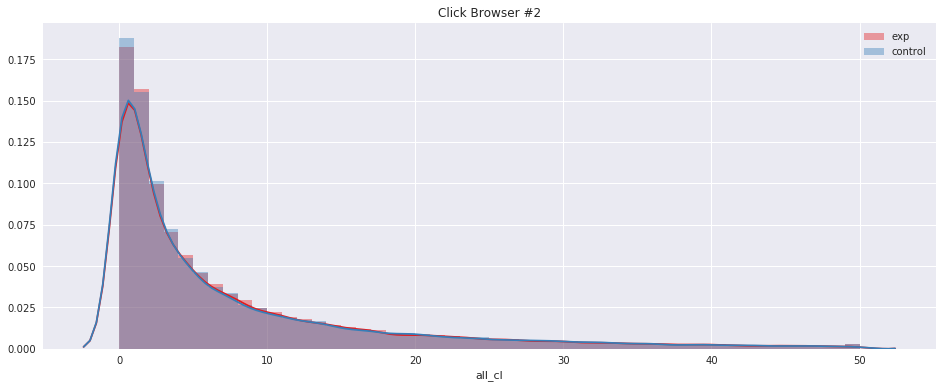

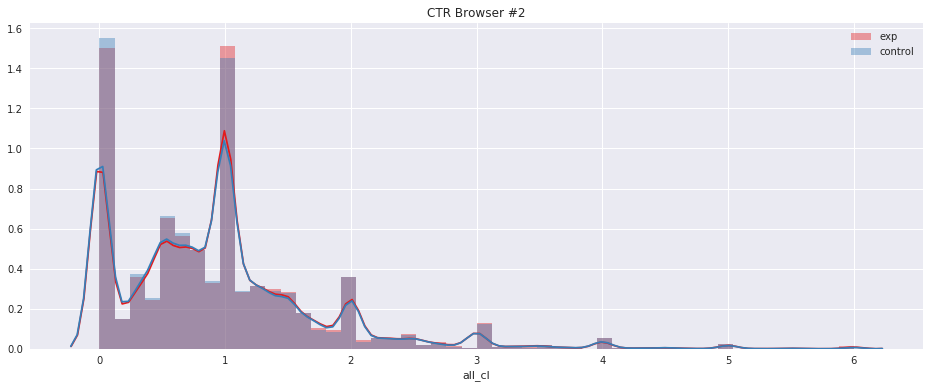

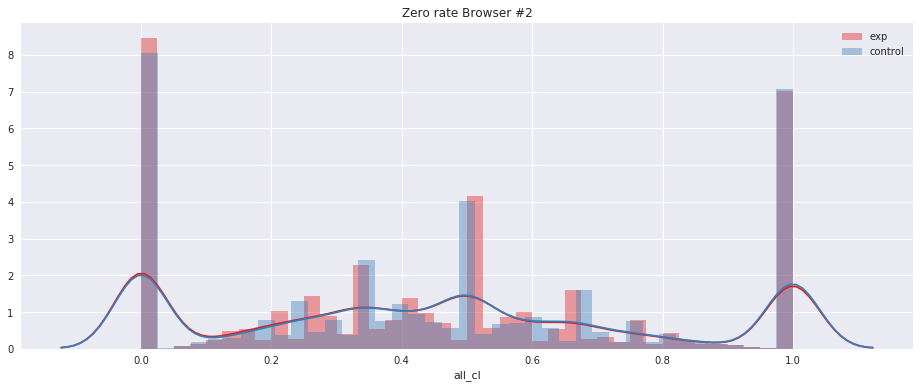

In [16]:
analyse_browser("Browser #2")

Clicks: p-value = 0.4076
CTR: p-value = 0.0000
Zero rate: p-value = 0.0000


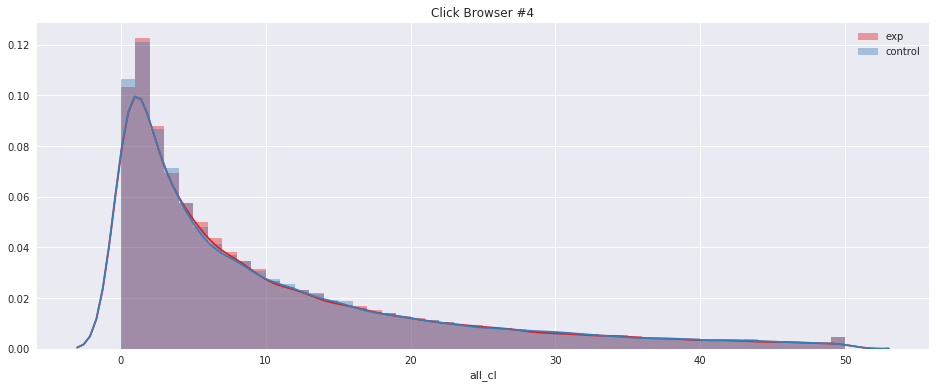

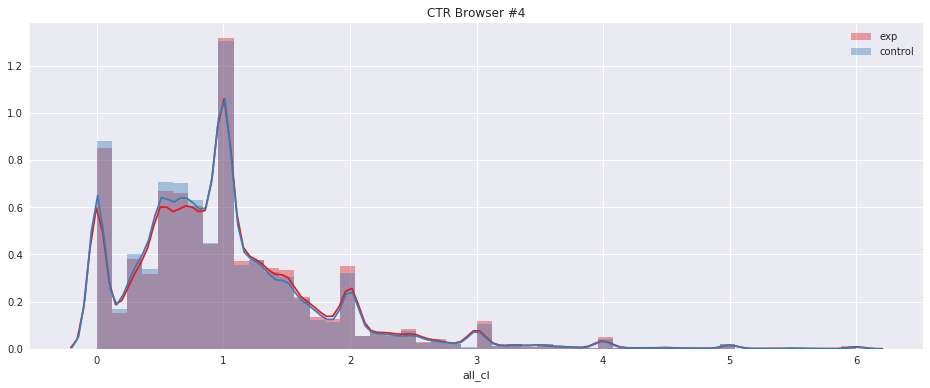

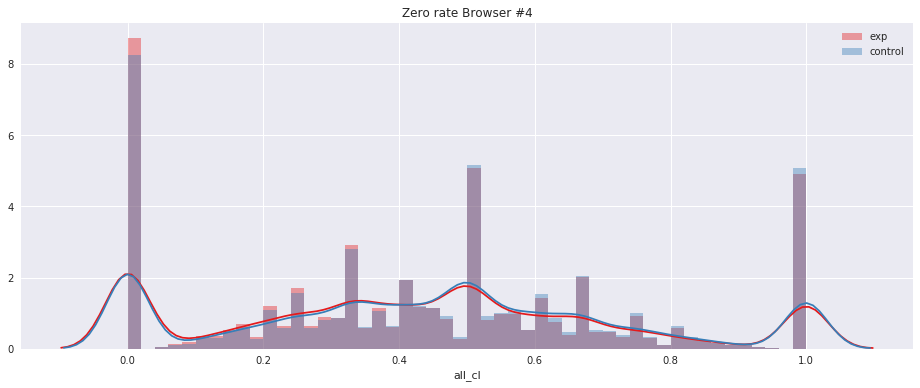

In [17]:
analyse_browser("Browser #4")

Clicks: p-value = 0.0000
CTR: p-value = 0.0000
Zero rate: p-value = 0.0000


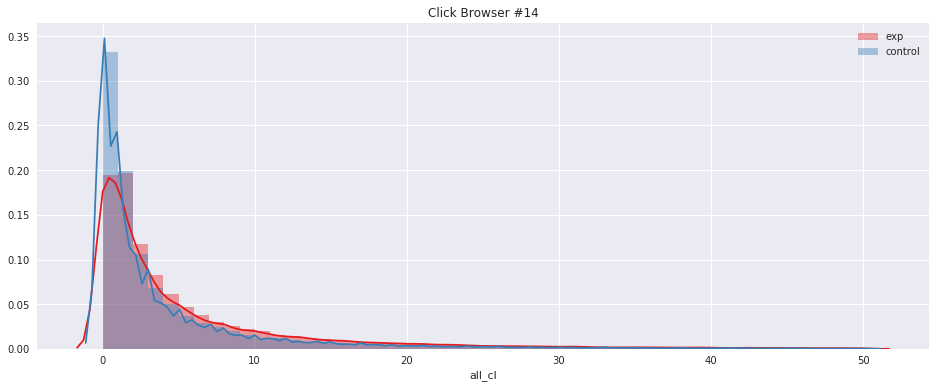

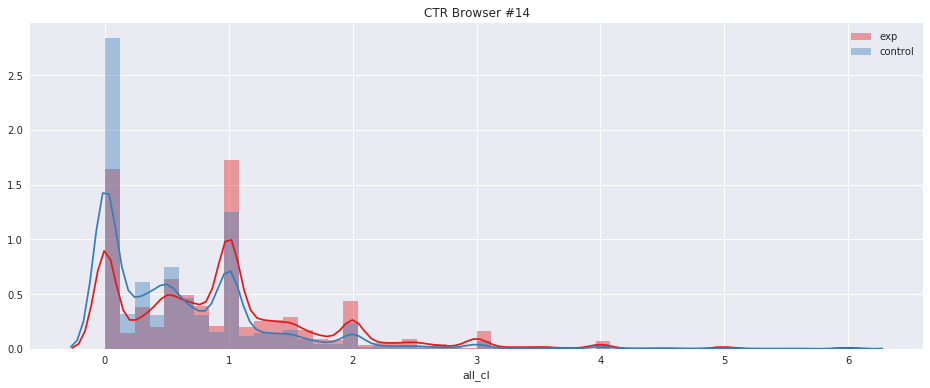

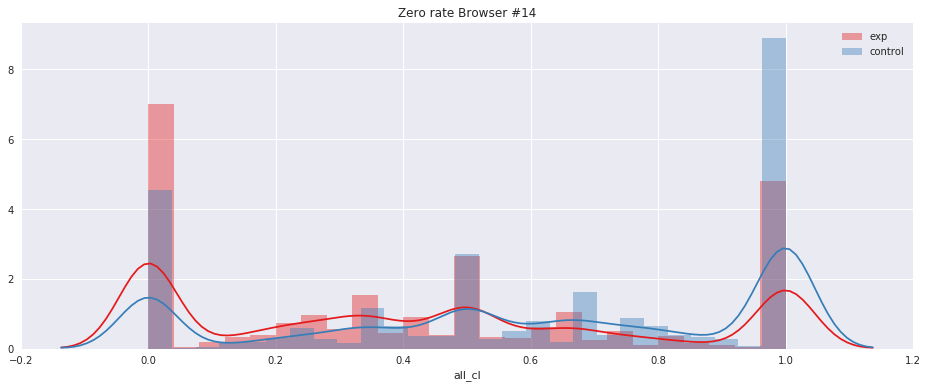

In [18]:
analyse_browser("Browser #14")

Clicks: p-value = 0.0374
CTR: p-value = 0.0710
Zero rate: p-value = 0.4828


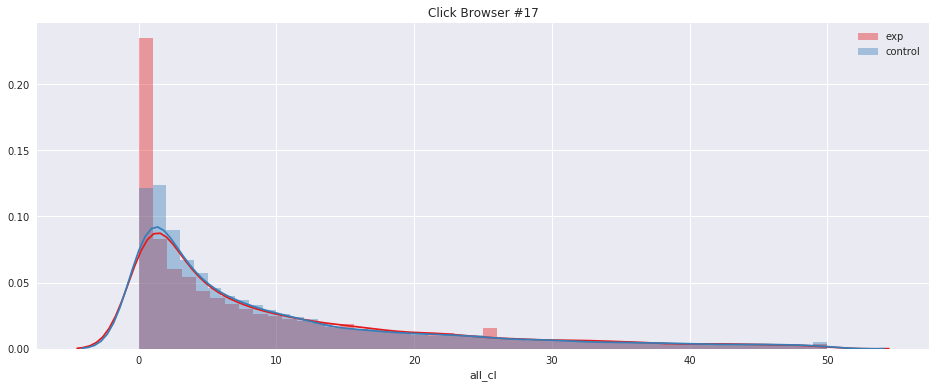

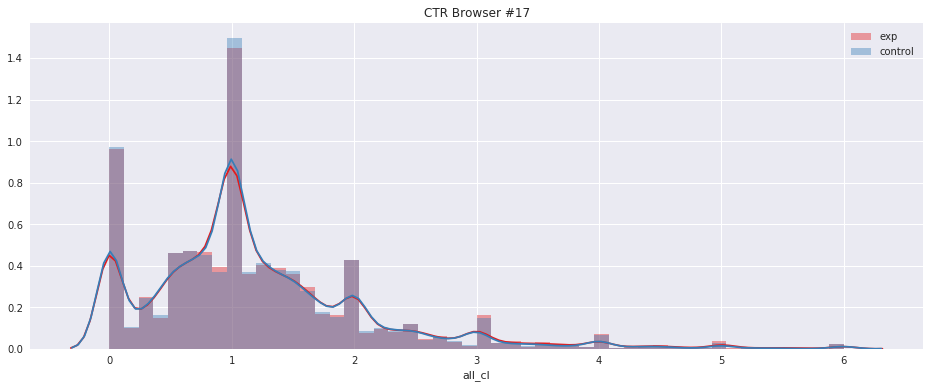

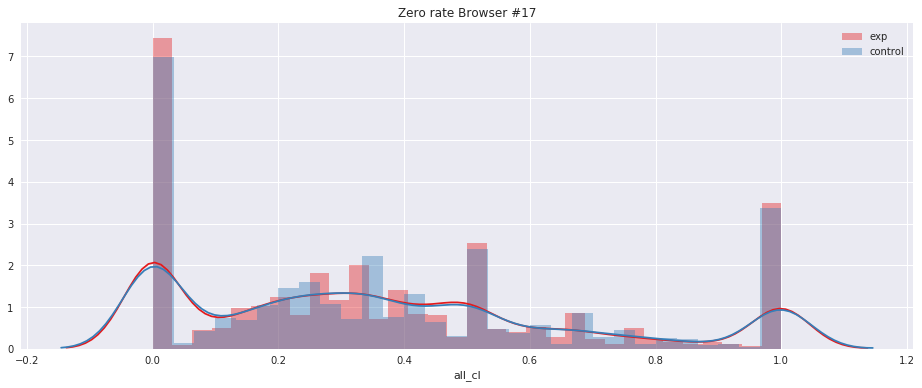

In [19]:
analyse_browser("Browser #17")

Clicks: p-value = 0.4537
CTR: p-value = 0.0017
Zero rate: p-value = 0.0000


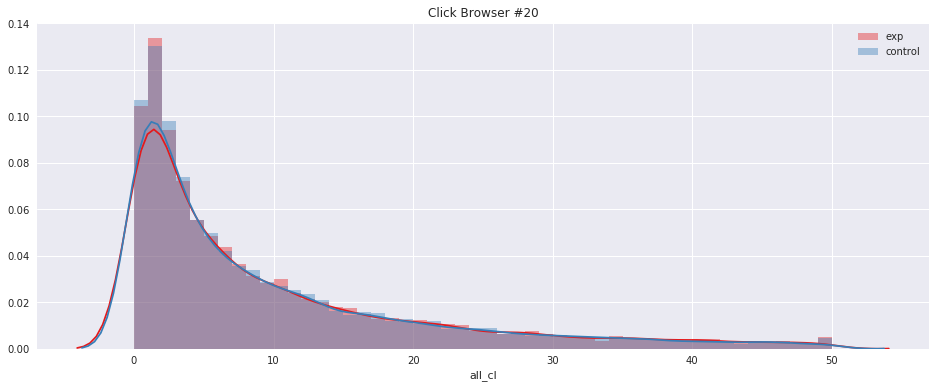

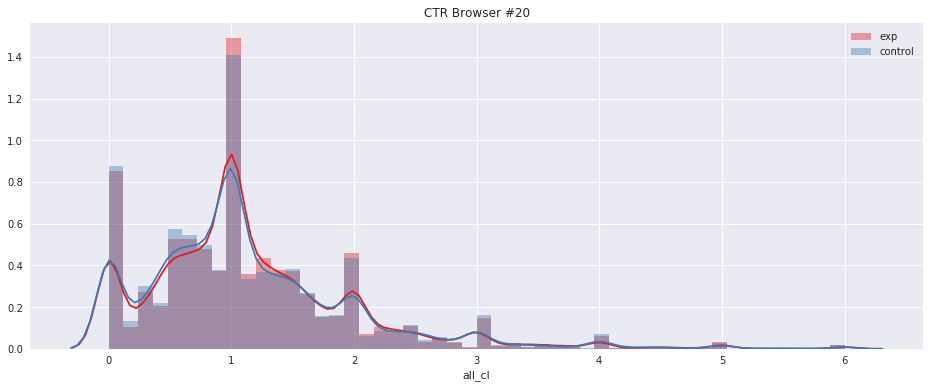

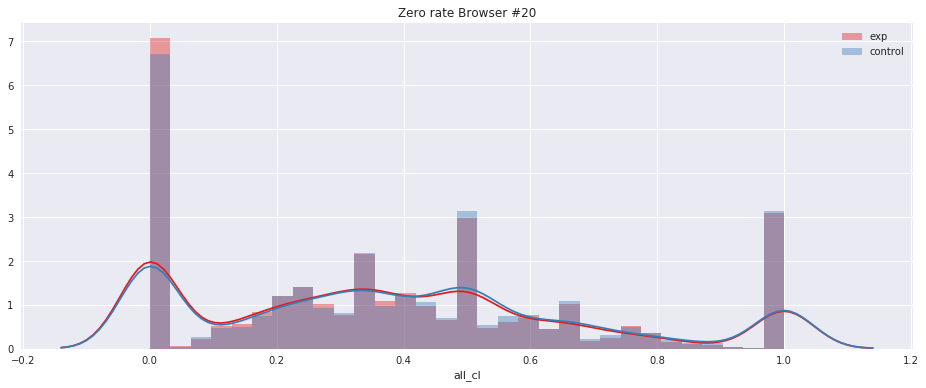

In [20]:
analyse_browser("Browser #20")

Clicks: p-value = 0.2574
CTR: p-value = 0.0007
Zero rate: p-value = 0.0034


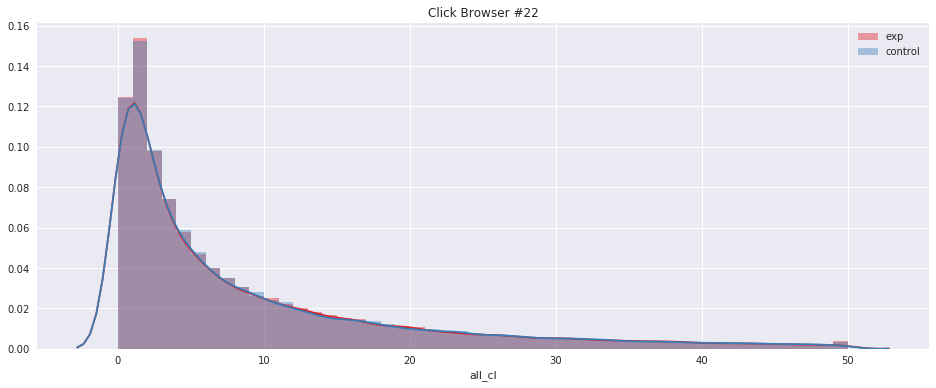

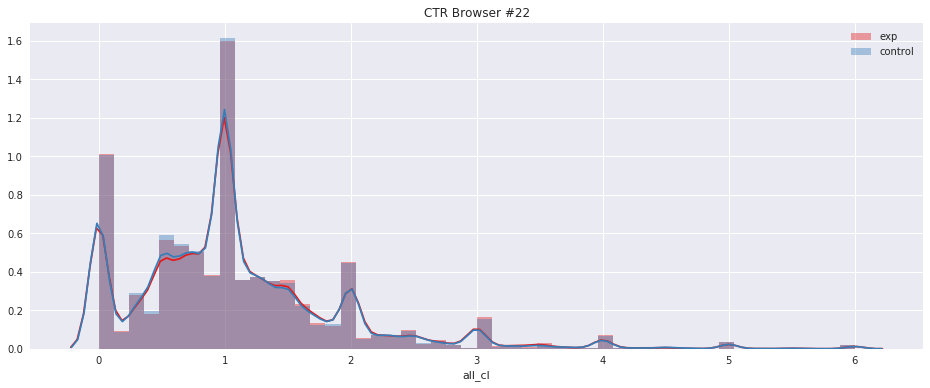

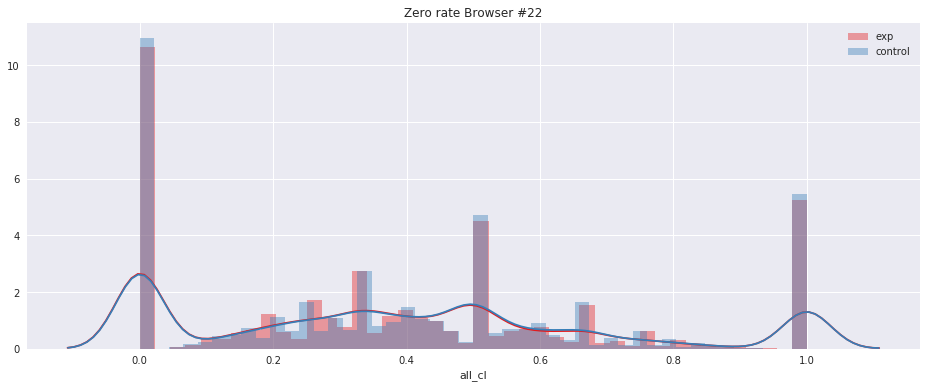

In [21]:
analyse_browser("Browser #22")

Let's try to exclude Browser #14.

p-value = 0.0894


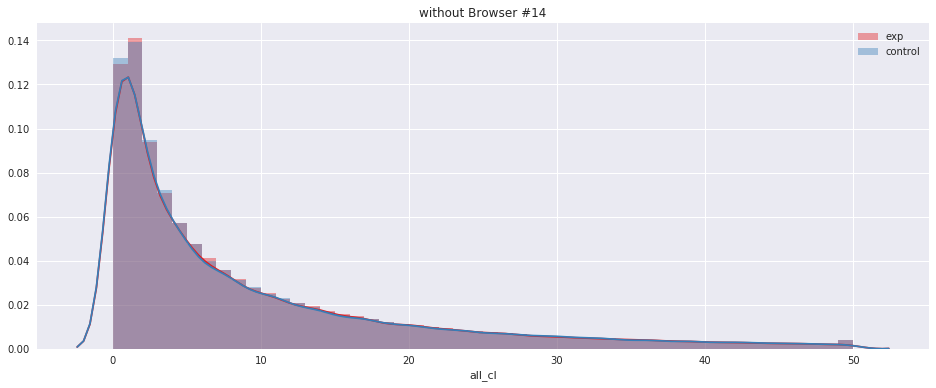

In [22]:
browser = "Browser #14"
exp_browser = agg_clicks(data.loc[(data.slot == "exp") & (data.browser != browser)])
control_browser = agg_clicks(data.loc[(data.slot == "control") & (data.browser != browser)])
plot_hist(exp_browser, control_browser, "without {}".format(browser))
p_value = mannwhitneyu(exp_browser, control_browser).pvalue
print("p-value = {p_value:0.4f}".format(p_value=p_value))

As we can see, Browser #14 has the smallest p-value. <br>
Browser #2 and Browser #17 have small p-values too. <br>
Other browsers have large p-values. <br>
If we exclude Browser #14, p-value is small, but it is not so small that we can conclude that experiment definitely affects these browsers.
Thus, we can conclude, that the experiment affected users of Browser #14 more than other users.

### Task 3

Unfortunately, without a context, it's difficult to be sure about the positive or negative influence of the experiment.

On the one hand, more clicks -- it's good because people use the product more actively; on the other hand, perhaps people need to do more click to do things they want, and it's bad.

Here we analyzed the total count of clicks per user.
But we lost some information, which can be important. <br>
For example, 5 sessions with 1 click per session and 1 session with 5 clicks -- it is the same in our solution.
But actually, it is not.

p-values for CTRs and zero rates are small almost for each browser. <br>
Also we can see small improvements of zero rate on experiment group. The number of small values increased and the number of big values decreased. The same thing with CTR. Especially it can be seen on the browser #14.

Thus, we can conclude that users begin to find things they want, and it gives us a hint that the experiment has a positive effect which significantly affects browser #14. <br>
Possibly developers have decided to test the new feature only in this browser.